In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying tennis.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Tennis - Le Tennis (1981) (Activision, Alan Miller) (AG-007, CAG-007) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/tennis.bin
copying space_invaders.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/space_invaders.bin
copying up_n_down.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/up_n_down.bin
copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/pyth

copying solaris.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Solaris (The Last Starfighter, Star Raiders II, Universe) (1986) (Atari, Douglas Neubauer, Mimi Nyden) (CX26136) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/solaris.bin


In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 600 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_600_1e-4.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_600_1e-4.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_6333/2992797741.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -21.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game fini

ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: 1.0 !!!!!!!!
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.961364545026917
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: 1.0 !!!!!!!!
ep 11: game finished, reward: -1.0
ep 11: game finished, reward

resetting env. episode reward total was -20.0. running mean: -20.87947587554421
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.880681116788768
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0

ep 29: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.86188235074204
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.86326352723462
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0


ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.808222648587723
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: ga

ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.768624427311007
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: 1.0 !!!!!!!!
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
e

ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.743367668552054
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: ga

ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.74888267609169
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: 1.0 !!!!!!!!
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep

ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: 1.0 !!!!!!!!
ep 79: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.72549620163919
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep

ep 88: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.682265027636525
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.68544237736016
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0

ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.664302878847774
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: 1.0 !!!!!!!!
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
e

ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.639232677026037
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finish

ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: 1.0 !!!!!!!!
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.644792327378603
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: gam

ep 127: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.665710664621834
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.669053557975616
ep 129: game finished, reward: -1.0
ep 129: ga

ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: 1.0 !!!!!!!!
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.5914025510463
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game 

resetting env. episode reward total was -21.0. running mean: -20.59887042920056
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.602881724908553
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: 1.0 !!!!!!!!
ep 

ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: 1.0 !!!!!!!!
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.589362704495652
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: gam

ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.509760442193357
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finish

ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: 1.0 !!!!!!!!
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.46995443804806
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game

ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
ep 184: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.42930857369337
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finishe

ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43611029426796
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finishe

ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
ep 203: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.465664137636306
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.488699174111613
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finish

ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: 1.0 !!!!!!!!
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.459170837530348
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: gam

ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: 1.0 !!!!!!!!
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.44761067816377
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game

ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43325347898693
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finishe

ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.41481208064608
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finishe

ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.451639088280334
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finish

resetting env. episode reward total was -21.0. running mean: -20.479556889198236
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.484761320306255
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: ga

ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: 1.0 !!!!!!!!
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.44196351900571
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: 1.0 !!!!!!!!
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 2

ep 289: game finished, reward: -1.0
ep 289: game finished, reward: 1.0 !!!!!!!!
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.413927574290206
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: gam

ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.42239105616351
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finishe

ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.458979517871377
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finish

ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.43744468683958
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finishe

ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.48153206857676
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: 1.0 !!!!!!!!
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game

ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.45987415648228
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: 1.0 !!!!!!!!
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: 1.0 !!!!!!!!
ep 338: game finished, reward: 1.0 !!!!!!!!
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -

ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: 1.0 !!!!!!!!
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.397242567061493
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: gam

ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: 1.0 !!!!!!!!
ep 356: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.371835928162714
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: gam

resetting env. episode reward total was -21.0. running mean: -20.35967268162567
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.366075954809414
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: gam

ep 375: game finished, reward: 1.0 !!!!!!!!
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.40157879764474
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: 1.0 !!!!!!!!
ep 376: game finished, reward: -1.0
ep 3

ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.382776145911667
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finish

ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.349580501814625
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finish

resetting env. episode reward total was -20.0. running mean: -20.347989046528934
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: 1.0 !!!!!!!!
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: 1.0 !!!!!!!!
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.3345091560

ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: 1.0 !!!!!!!!
ep 413: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.32480150728341
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game

ep 422: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.335532657539883
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: 1.0 !!!!!!!!
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.332177330964484
ep

ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35188998008848
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finishe

ep 441: game finished, reward: 1.0 !!!!!!!!
ep 441: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.3311625064265
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.337850881362236
ep 4

ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3183347053169
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished

ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.31022089775469
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: 1.0 !!!!!!!!
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: 1.0 !!!!!!!!
ep 461: game finished, reward: -1.0
ep 4

ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.320241838241653
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finish

ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.349525205115974
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: 1.0 !!!!!!!!
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.326392577290598
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finish

ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.316892862384666
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: gam

ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3352217115635
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: 1.0 !!!!!!!!
ep 509: game finished, reward: -1.0
ep 509: game 

ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.306896585419892
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: 1.0 !!!!!!!!
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: gam

ep 526: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.261129729511698
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: 1.0 !!!!!!!!
ep 527: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.2585184322

ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.218103075103922
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finish

ep 545: game finished, reward: 1.0 !!!!!!!!
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.24612167335302
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game

ep 554: game finished, reward: -1.0
ep 554: game finished, reward: -1.0
ep 554: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18843395955738
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.228372170901537
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finish

ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.274185043266282
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finish

ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28870741811881
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: 1.0 !!!!!!!!
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game

resetting env. episode reward total was -19.0. running mean: -20.244800888969863
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: 1.0 !!!!!!!!
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.242352880080162
ep 594: game finished, reward: -1.0
ep

ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.260125070008637
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finish

ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.293009501678874
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finish

ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.296698650703515
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: 1.0 !!!!!!!!
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: gam

ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30648306041285
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finishe

ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: 1.0 !!!!!!!!
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.308513899688002
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: gam

ep 649: game finished, reward: -1.0
ep 649: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.262815937555427
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: 1.0 !!!!!!!!
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.276519370891055
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: 1.0 !!!!!!!!
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: gam

ep 668: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.271722927652377
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.279005698375855
ep 670: game finished, reward: -1.0
ep 670: ga

ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.302925726150853
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: 1.0 !!!!!!!!
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: 1.0 !!!!!!!!
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: 1.0 !!!!!!!!
ep 679: game finished, reward: 

ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: 1.0 !!!!!!!!
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.303546282662538
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: gam

ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.287863514797426
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: 1.0 !!!!!!!!
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: 1.0 !!!!!!!!
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 

ep 706: game finished, reward: 1.0 !!!!!!!!
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: 1.0 !!!!!!!!
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: 1.0 !!!!!!!!
ep 706: game finished, reward: -1.0
ep 706: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -16.0. running mean: -20.165308343286213
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, 

ep 715: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.17955037018818
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: 1.0 !!!!!!!!
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.1777548664863
ep 71

ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.191883292994184
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finish

resetting env. episode reward total was -20.0. running mean: -20.20373482797749
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: 1.0 !!!!!!!!
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.201697479697717
ep 736: game finished, reward: -1.0
ep 

ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21336801697685
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finishe

ep 753: game finished, reward: -1.0
ep 753: game finished, reward: -1.0
ep 753: game finished, reward: -1.0
ep 753: game finished, reward: -1.0
ep 753: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18443982110506
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: 1.0 !!!!!!!!
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game

ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.12219331547696
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: 1.0 !!!!!!!!
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
resetting env. episode reward total was -20.0. r

ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
ep 772: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.177876336120626
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finish

ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.227079134846928
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finish

ep 791: game finished, reward: -1.0
ep 791: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.255680151199417
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.26947199065337
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: 1.0 !!!!!!!!
ep 802: game

ep 810: game finished, reward: -1.0
ep 810: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26653516888106
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27386981719225
ep 812: game

ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: 1.0 !!!!!!!!
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.2589329406076
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game 

ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: 1.0 !!!!!!!!
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: 1.0 !!!!!!!!
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.187036629556907
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: 1.0 !!!!!!!!
ep 830: game finished, reward: 

ep 838: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.188911502583526
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: 1.0 !!!!!!!!
ep 839: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18702238755769
ep 

ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18978737662387
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finishe

resetting env. episode reward total was -21.0. running mean: -20.221325240438865
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22911198803448
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: gam

ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.267139198232986
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: 1.0 !!!!!!!!
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: gam

ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: 1.0 !!!!!!!!
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.28021973086165
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game

ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.284813112286557
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: 1.0 !!!!!!!!
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: gam

ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.29505564599579
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finishe

ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.318164065648798
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 

ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: 1.0 !!!!!!!!
ep 915: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.28735768712722
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game

ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: 1.0 !!!!!!!!
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: 1.0 !!!!!!!!
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.27123769943699
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 9

resetting env. episode reward total was -19.0. running mean: -20.257672475209468
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.265095750457373
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: ga

ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.25206463987347
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finishe

ep 952: game finished, reward: 1.0 !!!!!!!!
ep 952: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.258417486428524
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: 1.0 !!!!!!!!
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
resetting env. episode reward total was

ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: 1.0 !!!!!!!!
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.222540657168874
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: gam

ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.23279292571004
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: 1.0 !!!!!!!!
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game

ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28750660121838
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finishe

ep 990: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.290901170795756
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.297992159087798
ep 992: game finished, reward: -1.0
ep 992: ga

ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.289600729457955
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward:

ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.322400666316767
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: 1.0 !!!!!!!!
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished,

ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.276275164207508
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: 1.0 !!!!!!!!
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished,

ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.213760346060916
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: 1.0 !!!!!!!!
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: 1.0 !!!!!!!!
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game f

resetting env. episode reward total was -21.0. running mean: -20.225253354524384
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: 1.0 !!!!!!!!
ep 1037: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.223000820979138
ep 1038: game fi

resetting env. episode reward total was -18.0. running mean: -20.18509837888565
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.193247395096797
ep 1047: game finished, reward: -1.0
ep 1047: game finished, r

ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21516732391043
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: 1.0 !!!!!!!!
ep 1056: game finished, 

ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19857376173043
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: 

ep 1073: game finished, reward: 1.0 !!!!!!!!
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.190537756162808
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished,

ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.175031913563537
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: 1.0 !!!!!!!!
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished,

ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.150581781401357
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: 1.0 !!!!!!!!
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: 1.0 !!!!!!!!
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game f

ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.100587025526668
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.140708666655904
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: 1.0 !!!!!!!!
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: 1.0 !!!!!!!!
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: 1.0 !!!!!!!!
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
resetti

ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
ep 1119: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.157612606031538
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward:

ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: 1.0 !!!!!!!!
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.11526389462566
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, 

ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: 1.0 !!!!!!!!
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
ep 1137: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.15256350677503
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, 

ep 1146: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.186836286692937
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: 1.0 !!!!!!!!
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.197608736089578
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished,

ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
ep 1165: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20858680108763
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: 

ep 1174: game finished, reward: -1.0
ep 1174: game finished, reward: -1.0
ep 1174: game finished, reward: -1.0
ep 1174: game finished, reward: -1.0
ep 1174: game finished, reward: -1.0
ep 1174: game finished, reward: -1.0
ep 1174: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.200073009120334
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: 1.0 !!!!!!!!
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished,

ep 1183: game finished, reward: -1.0
ep 1183: game finished, reward: -1.0
ep 1183: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.192578966672436
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
resetting env. episode reward t

ep 1192: game finished, reward: -1.0
ep 1192: game finished, reward: -1.0
ep 1192: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.1550643974822
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
resetting env. episode reward tot

ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
ep 1202: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.15812367485213
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: 

ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
ep 1211: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.202001019785
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1

ep 1220: game finished, reward: 1.0 !!!!!!!!
ep 1220: game finished, reward: -1.0
ep 1220: game finished, reward: -1.0
ep 1220: game finished, reward: -1.0
ep 1220: game finished, reward: -1.0
ep 1220: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.173952912624173
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: -1.0
ep 1221: game finished, reward: 1.0 !!!!!!!!
ep 1221

ep 1229: game finished, reward: -1.0
ep 1229: game finished, reward: -1.0
ep 1229: game finished, reward: -1.0
ep 1229: game finished, reward: -1.0
ep 1229: game finished, reward: -1.0
ep 1229: game finished, reward: -1.0
ep 1229: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.129001242067986
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward: -1.0
ep 1230: game finished, reward:

ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
ep 1239: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21228433597136
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: 

ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: 1.0 !!!!!!!!
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
ep 1248: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.193538262879446
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished, reward: -1.0
ep 1249: game finished,

ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
ep 1257: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.196119195748622
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward: -1.0
ep 1258: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.226531070295344
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
ep 1267: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.234265759592393
ep 1268: game finished, reward: -1.0
ep 1268: game finished, 

ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: 1.0 !!!!!!!!
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: 1.0 !!!!!!!!
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
ep 1276: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.21353019041285
ep 1277: game finished, reward: -1.0
ep 1277: game finished, reward: -1.0
ep 1277: game finished, reward: -1.0
ep 1277: game finished, reward: -1.0
ep 1277: game fi

ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: 1.0 !!!!!!!!
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: 1.0 !!!!!!!!
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
ep 1285: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.203326364116972
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game finished, reward: -1.0
ep 1286: game f

ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
ep 1294: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.184778409518334
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward: -1.0
ep 1295: game finished, reward:

ep 1303: game finished, reward: -1.0
ep 1303: game finished, reward: -1.0
ep 1303: game finished, reward: -1.0
ep 1303: game finished, reward: 1.0 !!!!!!!!
ep 1303: game finished, reward: -1.0
ep 1303: game finished, reward: -1.0
ep 1303: game finished, reward: -1.0
ep 1303: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.19770833119139
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, reward: -1.0
ep 1304: game finished, 

ep 1312: game finished, reward: -1.0
ep 1312: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20983542745882
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: 1.0 !!!!!!!!
ep 1313: game finished, reward: 1.0 !!!!!!!!
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: 1.0 !!!!!!!!
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313: game finished, reward: -1.0
ep 1313:

ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
ep 1322: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.209951085664255
ep 1323: game finished, reward: -1.0
ep 1323: game finished, reward: -1.0
ep 1323: game finished, reward: -1.0
ep 1323: game finished, reward: 1.0 !!!!!!!!
ep 1323: game finished,

ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: 1.0 !!!!!!!!
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: -1.0
ep 1331: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.220130451960284
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game finished, reward: -1.0
ep 1332: game f

ep 1340: game finished, reward: -1.0
ep 1340: game finished, reward: -1.0
ep 1340: game finished, reward: 1.0 !!!!!!!!
ep 1340: game finished, reward: -1.0
ep 1340: game finished, reward: -1.0
ep 1340: game finished, reward: -1.0
ep 1340: game finished, reward: -1.0
ep 1340: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22973706548144
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, reward: -1.0
ep 1341: game finished, 

ep 1349: game finished, reward: -1.0
ep 1349: game finished, reward: -1.0
ep 1349: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22890793222394
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
ep 1350: game finished, reward: -1.0
resetting env. episode reward to

ep 1358: game finished, reward: -1.0
ep 1358: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.189715009821658
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: -1.0
ep 1359: game finished, reward: 1.0 !!!!!!!!
ep 1359: game finished, reward: -1.0
resetting env. episode 

ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
ep 1368: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20069556682689
ep 1369: game finished, reward: -1.0
ep 1369: game finished, reward: -1.0
ep 1369: game finished, reward: -1.0
ep 1369: game finished, reward: -1.0
ep 1369: game finished, reward: 

ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: 1.0 !!!!!!!!
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
ep 1377: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18315826071622
ep 1378: game finished, reward: -1.0
ep 1378: game finished, reward: -1.0
ep 1378: game finished, reward: -1.0
ep 1378: game finished, reward: -1.0
ep 1378: game finished, reward: -1.0
ep 1378: game finished, reward: -1.0
ep 1378: game finished, reward: -1.0
ep 1378: game finished, 

ep 1386: game finished, reward: -1.0
ep 1386: game finished, reward: -1.0
ep 1386: game finished, reward: -1.0
ep 1386: game finished, reward: -1.0
ep 1386: game finished, reward: -1.0
ep 1386: game finished, reward: -1.0
ep 1386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22525288227638
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: 1.0 !!!!!!!!
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, reward: -1.0
ep 1387: game finished, 

ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: 1.0 !!!!!!!!
ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: -1.0
ep 1395: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.156673244498883
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: 1.0 !!!!!!!!
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: 1.0 !!!!!!!!
ep 1396: game finished, reward: -1.0
ep 1396: game finished, reward: -1.0
ep 1396

ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: 1.0 !!!!!!!!
ep 1404: game finished, reward: -1.0
ep 1404: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.10507159035947
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, reward: -1.0
ep 1405: game finished, 

ep 1413: game finished, reward: -1.0
ep 1413: game finished, reward: -1.0
ep 1413: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.144126047457192
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: 1.0 !!!!!!!!
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished, reward: -1.0
ep 1414: game finished,

ep 1422: game finished, reward: -1.0
ep 1422: game finished, reward: -1.0
ep 1422: game finished, reward: -1.0
ep 1422: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.101876214836874
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward: -1.0
ep 1423: game finished, reward:

ep 1431: game finished, reward: -1.0
ep 1431: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.082408770281194
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: 1.0 !!!!!!!!
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
ep 1432: game finished, reward: -1.0
resetting env. episode 

ep 1440: game finished, reward: -1.0
ep 1440: game finished, reward: -1.0
ep 1440: game finished, reward: -1.0
ep 1440: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.036658150112732
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: 1.0 !!!!!!!!
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: 1.0 !!!!!!!!
ep 1441: game finished, reward: -1.0
ep 1441: game finished, reward: -1.0
ep 1441: game f

resetting env. episode reward total was -21.0. running mean: -20.04358497942262
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
ep 1450: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.053149129628395
ep 1451: game finished, reward: -1.0
ep 1451: game finished, r

resetting env. episode reward total was -19.0. running mean: -20.019148085992004
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
ep 1459: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.028956605132084
ep 1460: game finished, reward: -1.0
ep 1460: game finished, 

ep 1467: game finished, reward: -1.0
ep 1467: game finished, reward: -1.0
ep 1467: game finished, reward: -1.0
ep 1467: game finished, reward: -1.0
ep 1467: game finished, reward: 1.0 !!!!!!!!
ep 1467: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.939184911165253
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished, reward: -1.0
ep 1468: game finished,

ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: -1.0
ep 1476: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.945027575948203
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: -1.0
ep 1477: game finished, reward: 1.0 !!!!!!!!
ep 1477: game finished, reward: -1.0
ep 1477: game finished,

ep 1485: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.940664931098695
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: 1.0 !!!!!!!!
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: 1.0 !!!!!!!!
ep 1486: game finished, reward: -1.0
ep 1486: game finished, reward: 1.0 !!!!!!!!
ep 1486

ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.918795289336316
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: 1.0 !!!!!!!!
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: 1.0 !!!!!!!!
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: -1.0
ep 1495: game finished, reward: 1.0 !!!!!!!!
ep 1495: game finished, reward: -1.0
ep 1495

ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.897664152742248
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: 1.0 !!!!!!!!
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: 1.0 !!!!!!!!
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game finished, reward: -1.0
ep 1504: game f

ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: 1.0 !!!!!!!!
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93704065758369
ep 1514: game finished, reward: -1.0
ep 1514: game finished, reward: -1.0
ep 1514: game finished, reward: -1.0
ep 1514: game finished, 

ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: 1.0 !!!!!!!!
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.97025341682983
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, reward: -1.0
ep 1523: game finished, 

ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.96331521965514
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: 1.0 !!!!!!!!
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: 1.0 !!!!!!!!
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game finished, reward: -1.0
ep 1532: game fi

ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.928930720310476
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: -1.0
ep 1541: game finished, reward: 1.0 !!!!!!!!
ep 1541: game finished, reward: -1.0
ep 1541: game finished,

ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.907502438788608
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward: -1.0
ep 1550: game finished, reward:

ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.896783865840472
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward:

ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.92377417314405
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: 

ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.94880389654146
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: 

ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.91383227044789
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: 1.0 !!!!!!!!
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, 

ep 1594: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.94106488444731
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: 1.0 !!!!!!!!
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: 1.0 !!!!!!!!
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
resetting env. e

ep 1603: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.927726250300957
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.938448987797948
ep 1605: game finished, 

ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.96308694935235
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: 

ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: 1.0 !!!!!!!!
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.927543003237844
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished,

ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: 1.0 !!!!!!!!
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
ep 1631: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.91381330178571
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, 

ep 1640: game finished, reward: 1.0 !!!!!!!!
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.9504826491378
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: 1.0 !!!!!!!!
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game fin

ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: 1.0 !!!!!!!!
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.925740509988415
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: 1.0 !!!!!!!!
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game f

ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.940975732218874
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward:

ep 1667: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.993553115778205
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: 1.0 !!!!!!!!
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: 1.0 !!!!!!!!
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.00425690801988
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, 

ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04261931287518
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: 

ep 1695: game finished, reward: 1.0 !!!!!!!!
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: 1.0 !!!!!!!!
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.998862785725667
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game f

ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.056714284674655
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: 1.0 !!!!!!!!
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished,

ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.099053353479057
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward:

ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.119232057247558
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward:

ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
ep 1732: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.089620354213807
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: 1.0 !!!!!!!!
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished,

ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: 1.0 !!!!!!!!
ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: -1.0
ep 1741: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.08178240327498
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, 

ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.05551036098363
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: 

resetting env. episode reward total was -20.0. running mean: -20.0988433242656
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: 1.0 !!!!!!!!
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running

ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.09121867988697
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: 

ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.112828034489368
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward:

ep 1787: game finished, reward: -1.0
ep 1787: game finished, reward: -1.0
ep 1787: game finished, reward: -1.0
ep 1787: game finished, reward: -1.0
ep 1787: game finished, reward: 1.0 !!!!!!!!
ep 1787: game finished, reward: -1.0
ep 1787: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.131520406328075
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: 1.0 !!!!!!!!
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: 1.0 !!!!!!!!
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788

ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.10217649408828
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: -1.0
ep 1797: game finished, reward: 1.0 !!!!!!!!
ep 1797: game finished, reward: -1.0
ep 1797: game finished, 

ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.09363694112311
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
ep 1806: game finished, reward: -1.0
resetting env. episode reward to

ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.018474794635623
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: -1.0
ep 1815: game finished, reward: 1.0 !!!!!!!!
ep 1815: game f

ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.988932599066295
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward: -1.0
ep 1824: game finished, reward:

ep 1832: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.028336829281603
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
ep 1833: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.038053460988788
ep 1834: game finished, 

resetting env. episode reward total was -19.0. running mean: -20.016465431869932
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
ep 1842: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.026300777551235
ep 1843: game finished, reward: -1.0
ep 1843: game finished, 

ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: 1.0 !!!!!!!!
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: 1.0 !!!!!!!!
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.99423196777949
ep 1852: game finished, reward: -1.0
ep 1852:

ep 1859: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.954866924006108
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.965318254766046
ep 1861: game finished, 

ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.006767658874313
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward: -1.0
ep 1870: game finished, reward:

ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.03529238172071
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: -1.0
ep 1879: game finished, reward: 

ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: 1.0 !!!!!!!!
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.993328200792707
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: 1.0 !!!!!!!!
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: 1.0 !!!!!!!!
ep 1888: game finished, reward: -1.0
ep 1888: game finished, reward: -1.0
ep 1888

ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.013313204381188
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: 1.0 !!!!!!!!
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished, reward: -1.0
ep 1897: game finished,

ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.974410447835467
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: 1.0 !!!!!!!!
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game finished, reward: -1.0
ep 1906: game f

ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: 1.0 !!!!!!!!
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: 1.0 !!!!!!!!
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.918168599934912
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915: game finished, reward: -1.0
ep 1915

ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.943498665178154
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward: -1.0
ep 1924: game finished, reward:

ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.9675047400986
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: 1

ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.96039841524453
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: 1.0 !!!!!!!!
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
resetting env. e

ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: 1.0 !!!!!!!!
ep 1951: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.003478381740088
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished, reward: -1.0
ep 1952: game finished,

ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.01316985666164
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: -1.0
ep 1961: game finished, reward: 

ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: 1.0 !!!!!!!!
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.97321406981328
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, reward: -1.0
ep 1970: game finished, 

ep 1978: game finished, reward: 1.0 !!!!!!!!
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: 1.0 !!!!!!!!
ep 1978: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.975995439380043
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: 1.0 !!!!!!!!
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979

ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: 1.0 !!!!!!!!
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.912442683949482
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished,

ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.94856493266383
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: 

ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97281703192914
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: 1.0 !!!!!!!!
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: 1.0 !!!!!!!!
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game fi

ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: 1.0 !!!!!!!!
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.888292067712115
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished,

ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.850397786750932
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: 1.0 !!!!!!!!
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished,

ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.854108293062172
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished,

ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.886050866391745
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: 1.0 !!!!!!!!
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished,

ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.915614342507055
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward:

ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: 1.0 !!!!!!!!
ep 2059: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.874588425740942
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished,

ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.894182464303626
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward:

ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: 1.0 !!!!!!!!
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: 1.0 !!!!!!!!
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.923325936989364
ep 2079: game finished, reward: -1.0
ep 2079: game finished, reward: -1.0
ep 2079: game f

ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.872088267694604
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: 1.0 !!!!!!!!
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished,

ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90382794848213
ep 2097: game finished, reward: -1.0
ep 2097: game finished, reward: -1.0
ep 2097: game finished, reward: -1.0
ep 2097: game finished, reward: -1.0
ep 2097: game finished, reward: 

ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: 1.0 !!!!!!!!
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.893697983375258
ep 2106: game finished, reward: -1.0
ep 2106: game finished, reward: -1.0
ep 2106: game finished, reward: -1.0
ep 2106: game finished, reward: -1.0
ep 2106: game finished,

ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: 1.0 !!!!!!!!
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: 1.0 !!!!!!!!
ep 2114: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.89365503504267
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game fi

ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.864996960496143
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward:

ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.93480025357832
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133:

ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.921698765707742
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward:

ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.96739220386777
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: 1.0 !!!!!!!!
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: 1.0 !!!!!!!!
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game fi

ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.951567085507428
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.962

ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.936359392615408
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: 1.0 !!!!!!!!
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: 1.0 !!!!!!!!
ep 2169: game finished, reward: -1.0
ep 2169: game f

ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: 1.0 !!!!!!!!
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.884400158077554
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: 1.0 !!!!!!!!
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game f

ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: 1.0 !!!!!!!!
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: 1.0 !!!!!!!!
ep 2186: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.846353165225388
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game f

ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.821795415492318
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: 1.0 !!!!!!!!
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished,

ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.87641208757657
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: 1.0 !!!!!!!!
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, 

ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.877397378934635
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: 1.0 !!!!!!!!
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished,

ep 2222: game finished, reward: 1.0 !!!!!!!!
ep 2222: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.877994598190014
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: 1.0 !!!!!!!!
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: 1.0 !!!!!!!!
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223

ep 2231: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88018998964205
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: 1.0 !!!!!!!!
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: 1.0 !!!!!!!!
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
resetting env. e

ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.91191585026476
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: 1.0 !!!!!!!!
ep 2242: game finished, 

ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: 1.0 !!!!!!!!
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: 1.0 !!!!!!!!
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.88196275796957
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game fi

ep 2258: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.844691069140307
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.856244158448906
ep 2260: game finished, 

ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: 1.0 !!!!!!!!
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
ep 2267: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.76193472480143
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: 1.0 !!!!!!!!
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game fi

ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: 1.0 !!!!!!!!
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: 1.0 !!!!!!!!
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
ep 2276: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.715444580976754
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game f

ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: -1.0
ep 2285: game finished, reward: 1.0 !!!!!!!!
ep 2285: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.72977514518767
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: 1.0 !!!!!!!!
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game fi

ep 2294: game finished, reward: 1.0 !!!!!!!!
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
ep 2294: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.714908458380908
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished,

ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: -1.0
ep 2303: game finished, reward: 1.0 !!!!!!!!
ep 2303: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.786934811636616
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: 1.0 !!!!!!!!
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: 1.0 !!!!!!!!
ep 2304

ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
ep 2312: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.749155124059865
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward:

ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: 1.0 !!!!!!!!
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
ep 2321: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.751237008786788
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished,

ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: 1.0 !!!!!!!!
ep 2330: game finished, reward: -1.0
ep 2330: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.734332708676167
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: 1.0 !!!!!!!!
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game f

ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: 1.0 !!!!!!!!
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: 1.0 !!!!!!!!
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
ep 2339: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.68035868707248
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game fi

ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
ep 2348: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.728089443668193
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward:

ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: 1.0 !!!!!!!!
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
ep 2357: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.74071995544583
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: -1.0
ep 2358: game finished, reward: 1.0 !!!!!!!!
ep 2358: game fi

ep 2366: game finished, reward: -1.0
ep 2366: game finished, reward: -1.0
ep 2366: game finished, reward: -1.0
ep 2366: game finished, reward: 1.0 !!!!!!!!
ep 2366: game finished, reward: -1.0
ep 2366: game finished, reward: -1.0
ep 2366: game finished, reward: -1.0
ep 2366: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.772651215400234
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished, reward: -1.0
ep 2367: game finished,

ep 2375: game finished, reward: -1.0
ep 2375: game finished, reward: 1.0 !!!!!!!!
ep 2375: game finished, reward: -1.0
ep 2375: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.802793203070713
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: 1.0 !!!!!!!!
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: 1.0 !!!!!!!!
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376: game finished, reward: -1.0
ep 2376

ep 2384: game finished, reward: 1.0 !!!!!!!!
ep 2384: game finished, reward: -1.0
ep 2384: game finished, reward: -1.0
ep 2384: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.80023838671489
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: -1.0
ep 2385: game finished, reward: 1.0 !!!!!!!!
ep 2385: game finished, reward: 1.0 !!!!!!!!
ep 2385: game finished, reward: -1.0
ep 2385:

ep 2393: game finished, reward: -1.0
ep 2393: game finished, reward: -1.0
ep 2393: game finished, reward: -1.0
ep 2393: game finished, reward: -1.0
ep 2393: game finished, reward: -1.0
ep 2393: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.778287932448556
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished, reward: -1.0
ep 2394: game finished,

ep 2402: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.81502131135379
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: 1.0 !!!!!!!!
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: -1.0
ep 2403: game finished, reward: 1.0 !!!!!!!!
resettin

ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.802870588667492
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: 1.0 !!!!!!!!
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: 1.0 !!!!!!!!
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: 1.0 !!!!!!!!
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: 1.0 !!!!!!!!
ep 2412: game finished, reward: -1.0
ep 2412: game finished, reward: -1.0

ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.793394234976393
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
ep 2421: game finished, reward: -1.0
resetting env. episode reward t

ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: 1.0 !!!!!!!!
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: 1.0 !!!!!!!!
ep 2429: game finished, reward: 1.0 !!!!!!!!
ep 2429: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.645702470296584
ep 2430: game finished, reward: -1.0
ep 2430: game finished, reward: -1.0
ep 2430: game finished, reward: -1.0
ep 2430: game finished, reward: -1.0
ep 2430

ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: 1.0 !!!!!!!!
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: 1.0 !!!!!!!!
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.648573224353736
ep 2439: game finished, reward: -1.0
ep 2439: game finished, reward: -1.0
ep 2439: game finished, reward: -1.0
ep 2439: game finished, reward: -1.0
ep 2439: game f

ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: 1.0 !!!!!!!!
ep 2447: game finished, reward: 1.0 !!!!!!!!
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: 1.0 !!!!!!!!
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.63110839254657
ep 2448: game finished, reward: -1.0
ep 2448:

ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.663501156701578
ep 2457: game finished, reward: -1.0
ep 2457: game finished, reward: -1.0
ep 2457: game finished, reward: -1.0
ep 2457: game finished, reward: -1.0
ep 2457: game finished, reward:

ep 2464: game finished, reward: 1.0 !!!!!!!!
ep 2464: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.622045063779233
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: 1.0 !!!!!!!!
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
resetting env. 

ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: 1.0 !!!!!!!!
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.58815948141072
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: 1.0 !!!!!!!!
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: 1.0 !!!!!!!!
ep 2474: game finished, reward: 1.0 !!!!!!!!
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0


ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: 1.0 !!!!!!!!
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: 1.0 !!!!!!!!
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
ep 2482: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.509038819617377
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: 1.0 !!!!!!!!
ep 2483: game finished, reward: -1.0
ep 2483

ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: 1.0 !!!!!!!!
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: 1.0 !!!!!!!!
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: 1.0 !!!!!!!!
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
ep 2491: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.53111223685562
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492:

ep 2499: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.499497731093292
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
ep 2500: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.51450275378236
ep 2501: game finished, r

resetting env. episode reward total was -21.0. running mean: -19.53271083358632
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: 1.0 !!!!!!!!
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
ep 2509: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.537383725250457
ep 2510: game fin

resetting env. episode reward total was -21.0. running mean: -19.554309268800928
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: 1.0 !!!!!!!!
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: 1.0 !!!!!!!!
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: 1.0 !!!!!!!!
ep 2518: game finished, reward: -1.0
ep 2518: game finished, reward: -1.0
resetti

ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: 1.0 !!!!!!!!
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
ep 2527: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.60843840090209
ep 2528: game finished, reward: -1.0
ep 2528: game finished, reward: -1.0
ep 2528: game finished, reward: -1.0
ep 2528: game finished, 

ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: 1.0 !!!!!!!!
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: 1.0 !!!!!!!!
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
ep 2536: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.603371279908657
ep 2537: game finished, reward: -1.0
ep 2537: game finished, reward: -1.0
ep 2537: game f

ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: 1.0 !!!!!!!!
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
ep 2545: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.64681096416856
ep 2546: game finished, reward: -1.0
ep 2546: game finished, reward: -1.0
ep 2546: game finished, reward: -1.0
ep 2546: game finished, reward: -1.0
ep 2546: game finished, reward: -1.0
ep 2546: game finished, 

ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: 1.0 !!!!!!!!
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
ep 2554: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.696099854469214
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: -1.0
ep 2555: game finished, reward: 1.0 !!!!!!!!
ep 2555: game f

ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
ep 2563: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.674457017326908
ep 2564: game finished, reward: -1.0
ep 2564: game finished, reward: -1.0
ep 2564: game finished, reward: -1.0
ep 2564: game finished, reward: -1.0
ep 2564: game finished, reward: -1.0
ep 2564: game finished, reward: -1.0
ep 2564: game finished, reward:

ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: 1.0 !!!!!!!!
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
ep 2572: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.693868641401522
ep 2573: game finished, reward: -1.0
ep 2573: game finished, reward: -1.0
ep 2573: game finished, reward: -1.0
ep 2573: game finished, reward: -1.0
ep 2573: game finished, reward: -1.0
ep 2573: game finished, reward: -1.0
ep 2573: game finished, reward: -1.0
ep 2573: game finished,

ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: 1.0 !!!!!!!!
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: -1.0
ep 2581: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.67364818981433
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: 1.0 !!!!!!!!
ep 2582: game finished, reward: -1.0
ep 2582: game finished, reward: -1.0
ep 2582:

ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: 1.0 !!!!!!!!
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
ep 2590: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.703017148360324
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: 1.0 !!!!!!!!
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game finished, reward: -1.0
ep 2591: game f

ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: 1.0 !!!!!!!!
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: 1.0 !!!!!!!!
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: 1.0 !!!!!!!!
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: 1.0 !!!!!!!!
ep 2599: game finished, reward: -1.0
ep 2599: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.652017173276047
ep 2600: game finished, reward: -1.0
ep 2600: game finished, reward: -1.0

ep 2607: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.64142877343829
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
ep 2608: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.655014485703905
ep 2609: game finished, r

resetting env. episode reward total was -21.0. running mean: -19.664098448077645
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
ep 2617: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.67745746359687
ep 2618: game finished, reward: -1.0
ep 2618: game finished, r

ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
ep 2626: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71505779004862
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: -1.0
ep 2627: game finished, reward: 

ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: 1.0 !!!!!!!!
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: 1.0 !!!!!!!!
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
ep 2635: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.73843583164638
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game finished, reward: -1.0
ep 2636: game fi

ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
ep 2644: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.70388967995795
ep 2645: game finished, reward: -1.0
ep 2645: game finished, reward: -1.0
ep 2645: game finished, reward: -1.0
ep 2645: game finished, reward: -1.0
ep 2645: game finished, reward: 

ep 2652: game finished, reward: -1.0
ep 2652: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.64863791400291
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: -1.0
ep 2653: game finished, reward: 1.0 !!!!!!!!
ep 2653: game finished, reward: -1.0
resetting env. e

ep 2661: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.669809833431824
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
ep 2662: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.683111735097505
ep 2663: game finished, 

ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: 1.0 !!!!!!!!
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
ep 2671: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.71984254192669
ep 2672: game finished, reward: -1.0
ep 2672: game finished, reward: -1.0
ep 2672: game finished, reward: -1.0
ep 2672: game finished, reward: 1.0 !!!!!!!!
ep 2672: game finished, reward: -1.0
ep 2672: game fi

ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: 1.0 !!!!!!!!
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
ep 2680: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.695737893094574
ep 2681: game finished, reward: -1.0
ep 2681: game finished, reward: -1.0
ep 2681: game finished, reward: -1.0
ep 2681: game finished,

ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: 1.0 !!!!!!!!
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
ep 2689: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.68361306727669
ep 2690: game finished, reward: -1.0
ep 2690: game finished, reward: -1.0
ep 2690: game finished, reward: -1.0
ep 2690: game finished, 

ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: 1.0 !!!!!!!!
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
ep 2698: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.691179990577805
ep 2699: game finished, reward: -1.0
ep 2699: game finished, reward: -1.0
ep 2699: game finished, reward: -1.0
ep 2699: game finished,

ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: 1.0 !!!!!!!!
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: 1.0 !!!!!!!!
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
ep 2707: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.679460677883025
ep 2708: game finished, reward: -1.0
ep 2708: game finished, reward: -1.0
ep 2708: game f

ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.656369794892953
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: 1.0 !!!!!!!!
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: 1.0 !!!!!!!!
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: 1.0 !!!!!!!!
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: -1.0
ep 2716: game finished, reward: 1.0 !!!!!!!!
ep 2716: game finished, reward: -1.0

ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: 1.0 !!!!!!!!
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: 1.0 !!!!!!!!
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.552330452388404
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game f

ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: 1.0 !!!!!!!!
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.591247941044823
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: 1.0 !!!!!!!!
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game f

ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: 1.0 !!!!!!!!
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.598539002382644
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: 1.0 !!!!!!!!
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game f

ep 2751: game finished, reward: 1.0 !!!!!!!!
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: 1.0 !!!!!!!!
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: 1.0 !!!!!!!!
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
ep 2751: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.585282879082214
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752

ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: 1.0 !!!!!!!!
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: 1.0 !!!!!!!!
ep 2760: game finished, reward: -1.0
ep 2760: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.572430916119835
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game f

ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: 1.0 !!!!!!!!
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: 1.0 !!!!!!!!
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
ep 2769: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.59911713847971
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game fi

ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: -1.0
ep 2778: game finished, reward: 1.0 !!!!!!!!
ep 2778: game finished, reward: 1.0 !!!!!!!!
ep 2778: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.6717309968537
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: 1.0 !!!!!!!!
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: 

ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: 1.0 !!!!!!!!
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: 1.0 !!!!!!!!
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
ep 2787: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.660914525893666
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: 1.0 !!!!!!!!
ep 2788: game finished, reward: -1.0
ep 2788: game finished, reward: -1.0
ep 2788

ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
ep 2796: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.700905252993415
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: 1.0 !!!!!!!!
ep 2797: game finished, reward: 1.0 !!!!!!!!
ep 2797: game finished, reward: 1.0 !!!!!!!!
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797: game finished, reward: -1.0
ep 2797

ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: 1.0 !!!!!!!!
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
ep 2805: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.66898475379463
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, reward: -1.0
ep 2806: game finished, 

ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: 1.0 !!!!!!!!
ep 2814: game finished, reward: -1.0
ep 2814: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.660799910671646
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game finished, reward: -1.0
ep 2815: game f

ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: 1.0 !!!!!!!!
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: -1.0
ep 2823: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.651598471006277
ep 2824: game finished, reward: -1.0
ep 2824: game finished, reward: -1.0
ep 2824: game finished, reward: -1.0
ep 2824: game finished, reward: -1.0
ep 2824: game f

ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
ep 2832: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.653876928237572
ep 2833: game finished, reward: -1.0
ep 2833: game finished, reward: -1.0
ep 2833: game finished, reward: -1.0
ep 2833: game finished, reward: -1.0
ep 2833: game finished, reward:

ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
ep 2841: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.664511426577064
ep 2842: game finished, reward: -1.0
ep 2842: game finished, reward: -1.0
ep 2842: game finished, reward: -1.0
ep 2842: game finished, reward: -1.0
ep 2842: game finished, reward:

ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: 1.0 !!!!!!!!
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.592017699428812
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished, reward: -1.0
ep 2850: game finished,

ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: 1.0 !!!!!!!!
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
ep 2859: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.658891081464912
ep 2860: game finished, reward: -1.0
ep 2860: game finished, reward: -1.0
ep 2860: game finished, reward: -1.0
ep 2860: game finished,

ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
ep 2868: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.688394157576507
ep 2869: game finished, reward: -1.0
ep 2869: game finished, reward: -1.0
ep 2869: game finished, reward: -1.0
ep 2869: game finished, reward: -1.0
ep 2869: game finished, reward: -1.0
ep 2869: game finished, reward:

ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
ep 2877: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.725714380185277
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward: -1.0
ep 2878: game finished, reward:

ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: 1.0 !!!!!!!!
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: -1.0
ep 2886: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.738091297379874
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game finished, reward: -1.0
ep 2887: game f

ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: 1.0 !!!!!!!!
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: 1.0 !!!!!!!!
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
ep 2895: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.66515471017167
ep 2896: game finished, reward: -1.0
ep 2896: game finished, reward: -1.0
ep 2896: game fi

ep 2903: game finished, reward: -1.0
ep 2903: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.643759158290646
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
ep 2904: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.657

ep 2912: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.663713868258778
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: 1.0 !!!!!!!!
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
ep 2913: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: 1.0 !!!!!!!!
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.575559234985775
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: -1.0
ep 2922: game finished, reward: 1.0 !!!!!!!!
ep 2922: game f

ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: 1.0 !!!!!!!!
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: 1.0 !!!!!!!!
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: 1.0 !!!!!!!!
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.55470876495227
ep 2931: game finished, reward: -1.0
ep 2931: game finished, reward: -1.0
ep 2931: game finished, reward: -1.0
ep 2931: game finished, reward: -1.0
ep 2931: game finished, reward: -1.0
ep 2931: game finished, reward: -1.0
ep 2931:

ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: 1.0 !!!!!!!!
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.463326858315373
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: 1.0 !!!!!!!!
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: 1.0 !!!!!!!!
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0

ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.462767936992506
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward:

ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: 1.0 !!!!!!!!
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.460901571073236
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished,

ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: 1.0 !!!!!!!!
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.45055810091299
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, 

ep 2973: game finished, reward: 1.0 !!!!!!!!
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.405558987747984
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
resetting env. episode 

ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: 1.0 !!!!!!!!
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: 1.0 !!!!!!!!
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.36845575685142
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game fi

ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: 1.0 !!!!!!!!
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: 1.0 !!!!!!!!
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.374351611716925
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: 1.0 !!!!!!!!
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992

ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.399829900393804
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward:

ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.42291925564403
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: 

ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.406154699971044
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward:

ep 3026: game finished, reward: -1.0
ep 3026: game finished, reward: -1.0
ep 3026: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.36429469948038
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
resetting env. episode reward to

ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
ep 3035: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.31309708856863
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: 

ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: -1.0
ep 3044: game finished, reward: 1.0 !!!!!!!!
ep 3044: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.39163462228905
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, reward: -1.0
ep 3045: game finished, 

ep 3053: game finished, reward: 1.0 !!!!!!!!
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
ep 3053: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.404460360239415
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished, reward: -1.0
ep 3054: game finished,

ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
ep 3062: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.446276862776735
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: 1.0 !!!!!!!!
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished, reward: -1.0
ep 3063: game finished,

ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
ep 3071: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.493588957693863
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: 1.0 !!!!!!!!
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: 1.0 !!!!!!!!
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game finished, reward: -1.0
ep 3072: game f

ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
ep 3080: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.43266254223481
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: -1.0
ep 3081: game finished, reward: 

ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: 1.0 !!!!!!!!
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: 1.0 !!!!!!!!
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: 1.0 !!!!!!!!
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
ep 3089: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.450860961266052
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090: game finished, reward: -1.0
ep 3090

ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
ep 3098: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.47183327005399
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: -1.0
ep 3099: game finished, reward: 

resetting env. episode reward total was -18.0. running mean: -19.45305256604705
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: -1.0
ep 3107: game finished, reward: 1.0 !!!!!!!!
ep 3107: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.458522040386576
ep 3108: game fin

ep 3115: game finished, reward: -1.0
ep 3115: game finished, reward: -1.0
ep 3115: game finished, reward: -1.0
ep 3115: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.451156966712073
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: 1.0 !!!!!!!!
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: 1.0 !!!!!!!!
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: 1.0 !!!!!!!!
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116: game finished, reward: -1.0
ep 3116

ep 3124: game finished, reward: -1.0
ep 3124: game finished, reward: -1.0
ep 3124: game finished, reward: -1.0
ep 3124: game finished, reward: -1.0
ep 3124: game finished, reward: -1.0
ep 3124: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.461257470826748
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: 1.0 !!!!!!!!
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished, reward: -1.0
ep 3125: game finished,

ep 3133: game finished, reward: -1.0
ep 3133: game finished, reward: -1.0
ep 3133: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.50861125732393
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: 1.0 !!!!!!!!
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: 1.0 !!!!!!!!
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: 1.0 !!!!!!!!
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134: game finished, reward: -1.0
ep 3134:

ep 3142: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.55149043953063
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: 1.0 !!!!!!!!
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: 1.0 !!!!!!!!
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: 1.0 !!!!!!!!
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143: game finished, reward: -1.0
ep 3143:

ep 3151: game finished, reward: -1.0
ep 3151: game finished, reward: -1.0
ep 3151: game finished, reward: -1.0
ep 3151: game finished, reward: -1.0
ep 3151: game finished, reward: 1.0 !!!!!!!!
ep 3151: game finished, reward: -1.0
ep 3151: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.51388638238729
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: 1.0 !!!!!!!!
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: 1.0 !!!!!!!!
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: 1.0 !!!!!!!!
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0
ep 3152: game finished, reward: -1.0


ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: 1.0 !!!!!!!!
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
ep 3160: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.499413029187053
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished, reward: -1.0
ep 3161: game finished,

ep 3169: game finished, reward: 1.0 !!!!!!!!
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: 1.0 !!!!!!!!
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
ep 3169: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.463420762670868
ep 3170: game finished, reward: -1.0
ep 3170: game finished, reward: -1.0
ep 3170: game finished, reward: -1.0
ep 3170: game finished, reward: 1.0 !!!!!!!!
ep 3170: game finished, reward: -1.0
ep 3170

ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
ep 3178: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.500894175312943
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward: -1.0
ep 3179: game finished, reward:

ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: 1.0 !!!!!!!!
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: 1.0 !!!!!!!!
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
ep 3187: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.524454230828823
ep 3188: game finished, reward: -1.0
ep 3188: game finished, reward: -1.0
ep 3188: game finished, reward: -1.0
ep 3188: game finished, reward: -1.0
ep 3188: game finished, reward: -1.0
ep 3188: game finished, reward: -1.0
ep 3188: game finished, reward: -1.0
ep 3188: game f

ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
ep 3196: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.584230788716614
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward: -1.0
ep 3197: game finished, reward:

ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: 1.0 !!!!!!!!
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
ep 3205: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.58193950508666
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, reward: -1.0
ep 3206: game finished, 

ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: 1.0 !!!!!!!!
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: 1.0 !!!!!!!!
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: 1.0 !!!!!!!!
ep 3214: game finished, reward: -1.0
ep 3214: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.558419728124473
ep 3215: game finished, reward: -1.0
ep 3215: game finished, reward: -1.0
ep 3215: game finished, reward: -1.0
ep 3215: game finished, reward: -1.0
ep 3215: game finished, reward: -1.0
ep 3215

ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: 1.0 !!!!!!!!
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: 1.0 !!!!!!!!
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
ep 3223: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.568453686455907
ep 3224: game finished, reward: -1.0
ep 3224: game finished, reward: -1.0
ep 3224: game finished, reward: -1.0
ep 3224: game finished, reward: -1.0
ep 3224: game f

ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: 1.0 !!!!!!!!
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: -1.0
ep 3232: game finished, reward: 1.0 !!!!!!!!
ep 3232: game finished, reward: 1.0 !!!!!!!!
ep 3232: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.567628526398483
ep 3233: game finished, reward: -1.0
ep 3233: game finished, reward: -1.0
ep 3233: game finished, reward: -1.0
ep 3233

ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: 1.0 !!!!!!!!
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: 1.0 !!!!!!!!
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.47380359730723
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game finished, reward: -1.0
ep 3241: game fi

ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: 1.0 !!!!!!!!
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: 1.0 !!!!!!!!
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.452252078661495
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: -1.0
ep 3250: game finished, reward: 1.0 !!!!!!!!
ep 3250: game finished, reward: -1.0
ep 3250

ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.37051179180566
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: 1.0 !!!!!!!!
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game fi

ep 3266: game finished, reward: 1.0 !!!!!!!!
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: 1.0 !!!!!!!!
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: 1.0 !!!!!!!!
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.335362436619913
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: 1.0 !!!!!!!!
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0

ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: -1.0
ep 3275: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.33450866588151
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, 

ep 3283: game finished, reward: -1.0
ep 3283: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.288284750161402
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: 1.0 !!!!!!!!
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: 1.0 !!!!!!!!
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: 1.0 !!!!!!!!
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284: game finished, reward: -1.0
ep 3284

ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
ep 3292: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.246553725064526
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward: -1.0
ep 3293: game finished, reward:

ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: 1.0 !!!!!!!!
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: 1.0 !!!!!!!!
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
ep 3301: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.205740568508123
ep 3302: game finished, reward: -1.0
ep 3302: game finished, reward: -1.0
ep 3302: game f

ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: 1.0 !!!!!!!!
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.13211131632545
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: 1.0 !!!!!!!!
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game finished, reward: -1.0
ep 3310: game fi

ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
ep 3318: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.19026265662572
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: -1.0
ep 3319: game finished, reward: 

ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.269708713380073
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: 1.0 !!!!!!!!
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: 1.0 !!!!!!!!
ep 3328: game finished, reward: -1.0
ep 3328: game finished, reward: -1.0
ep 3328: game f

ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
ep 3336: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.26560723405834
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: -1.0
ep 3337: game finished, reward: 

ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: 1.0 !!!!!!!!
ep 3345: game finished, reward: 1.0 !!!!!!!!
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
ep 3345: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.232831888373713
ep 3346: game finished, reward: -1.0
ep 3346: game finished, reward: -1.0
ep 3346: game f

ep 3353: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.2429908036765
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
ep 3354: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.260560895639735
ep 3355: game finished, re

ep 3362: game finished, reward: -1.0
ep 3362: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.277901212183096
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: 1.0 !!!!!!!!
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
ep 3363: game finished, reward: -1.0
resetting env. episode 

ep 3371: game finished, reward: -1.0
ep 3371: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.321342283341224
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: -1.0
ep 3372: game finished, reward: 1.0 !!!!!!!!
ep 3372: game finished, reward: -1.0
resetting env. episode 

ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: 1.0 !!!!!!!!
ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: 1.0 !!!!!!!!
ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: 1.0 !!!!!!!!
ep 3380: game finished, reward: -1.0
ep 3380: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.273735957366124
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: -1.0
ep 3381: game finished, reward: 1.0 !!!!!!!!

ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: 1.0 !!!!!!!!
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: 1.0 !!!!!!!!
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
ep 3389: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.267821685867546
ep 3390: game finished, reward: -1.0
ep 3390: game finished, reward: -1.0
ep 3390: game finished, reward: -1.0
ep 3390: game finished, reward: -1.0
ep 3390: game finished, reward: -1.0
ep 3390: game finished, reward: -1.0
ep 3390: game finished, reward: -1.0
ep 3390: game f

ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: 1.0 !!!!!!!!
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: 1.0 !!!!!!!!
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
ep 3398: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.292796204163235
ep 3399: game finished, reward: -1.0
ep 3399: game finished, reward: -1.0
ep 3399: game finished, reward: -1.0
ep 3399: game finished, reward: -1.0
ep 3399: game f

ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: 1.0 !!!!!!!!
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.22883810378642
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: 1.0 !!!!!!!!
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407: game finished, reward: -1.0
ep 3407:

ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: 1.0 !!!!!!!!
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: 1.0 !!!!!!!!
ep 3415: game finished, reward: 1.0 !!!!!!!!
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.13158260484419
ep 3416: game finished, reward: -1.0
ep 3416:

ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.130734941596987
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: 1.0 !!!!!!!!
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: 1.0 !!!!!!!!
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: 1.0 !!!!!!!!
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0

ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.157564206400497
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: 1.0 !!!!!!!!
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: 1.0 !!!!!!!!
ep 3433: game finished, reward: -1.0

ep 3441: game finished, reward: 1.0 !!!!!!!!
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: 1.0 !!!!!!!!
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.183616319232392
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game f

ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: 1.0 !!!!!!!!
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.25489571614275
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, 

ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.22356395440265
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: 

ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
ep 3467: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.17629839338638
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: 1.0 !!!!!!!!
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: 1.0 !!!!!!!!
ep 3468: game finished, reward: -1.0
ep 3468: game fi

ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: 1.0 !!!!!!!!
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
ep 3476: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.208319710228206
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: 1.0 !!!!!!!!
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game f

ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
ep 3485: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.24873705591959
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0


ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: 1.0 !!!!!!!!
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
ep 3494: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.17273334561224
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: 1.0 !!!!!!!!
ep 3495: game finished, reward: -1.0
ep 3495: game fi

ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: 1.0 !!!!!!!!
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: 1.0 !!!!!!!!
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: 1.0 !!!!!!!!
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.205061879879498
ep 3504: game finished, reward: -1.0
ep 3504

ep 3511: game finished, reward: -1.0
ep 3511: game finished, reward: -1.0
ep 3511: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.216984829744362
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
resetting env. episode reward t

ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: 1.0 !!!!!!!!
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
ep 3520: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.20715561482326
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: 1.0 !!!!!!!!
ep 3521: game fi

ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: 1.0 !!!!!!!!
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: 1.0 !!!!!!!!
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: 1.0 !!!!!!!!
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: 1.0 !!!!!!!!
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: 1.0 !!!!!!!!
ep 3529: game finished, reward: -1.0
ep 3529: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.152795015380125
ep 3530: game finished, rewa

ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: 1.0 !!!!!!!!
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: 1.0 !!!!!!!!
ep 3538: game finished, reward: -1.0
ep 3538: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.20471081323292
ep 3539: game finished, reward: -1.0
ep 3539:

ep 3546: game finished, reward: 1.0 !!!!!!!!
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
ep 3546: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.14057109431865
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: 1.0 !!!!!!!!
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game finished, reward: -1.0
ep 3547: game fi

ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: 1.0 !!!!!!!!
ep 3555: game finished, reward: -1.0
ep 3555: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.13869546626972
ep 3556: game finished, reward: -1.0
ep 3556: game finished, reward: -1.0
ep 3556: game finished, reward: -1.0
ep 3556: game finished, reward: -1.0
ep 3556: game finished, reward: -1.0
ep 3556: game finished, 

ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
ep 3564: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.213089315671745
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward: -1.0
ep 3565: game finished, reward:

resetting env. episode reward total was -19.0. running mean: -19.196611480111248
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
ep 3573: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.214645365310137
ep 3574: game finished, reward: -1.0
ep 3574: game finished, 

ep 3581: game finished, reward: -1.0
ep 3581: game finished, reward: -1.0
ep 3581: game finished, reward: -1.0
ep 3581: game finished, reward: -1.0
ep 3581: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.188631407245435
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: 1.0 !!!!!!!!
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: 1.0 !!!!!!!!
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: 1.0 !!!!!!!!
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: 1.0 !!!!!!!!
ep 3582: game finished, reward: -1.0
ep 3582: game finished, reward: -1.0

ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: 1.0 !!!!!!!!
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: 1.0 !!!!!!!!
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
ep 3590: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.12578291732936
ep 3591: game finished, reward: -1.0
ep 3591: game finished, reward: -1.0
ep 3591: game finished, reward: -1.0
ep 3591: game finished, reward: -1.0
ep 3591: game finished, reward: -1.0
ep 3591: game fi

ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: 1.0 !!!!!!!!
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: 1.0 !!!!!!!!
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.01920326414027
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game finished, reward: -1.0
ep 3599: game fi

ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: 1.0 !!!!!!!!
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: 1.0 !!!!!!!!
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.064720275516475
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game finished, reward: -1.0
ep 3608: game f

ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: 1.0 !!!!!!!!
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.069601513178075
ep 3617: game finished, reward: -1.0
ep 3617: game finished, reward: -1.0
ep 3617: game finished, reward: -1.0
ep 3617: game finished,

ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.08314907999229
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: 1.0 !!!!!!!!
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: 1.0 !!!!!!!!
ep 3625: game finished, reward: -1.0
ep 3625: game fi

ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: 1.0 !!!!!!!!
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: 1.0 !!!!!!!!
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: 1.0 !!!!!!!!
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.047794236474907
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634

ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -14.0. running mean: -19.03247295549388
ep 3643: game

ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.06005245540436
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: 1.0 !!!!!!!!
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: 1.0 !!!!!!!!
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: 1.0 !!!!!!!!
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: 1.0 !!!!!!!!
ep 3651: game finished, reward: -1.0


ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.11259776082123
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: 

ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.113744960580632
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: 1.0 !!!!!!!!
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: 1.0 !!!!!!!!
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: 1.0 !!!!!!!!
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669

ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: 1.0 !!!!!!!!
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: 1.0 !!!!!!!!
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.151458465511627
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game f

ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.176997375590396
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward:

ep 3694: game finished, reward: -1.0
ep 3694: game finished, reward: -1.0
ep 3694: game finished, reward: -1.0
ep 3694: game finished, reward: -1.0
ep 3694: game finished, reward: 1.0 !!!!!!!!
ep 3694: game finished, reward: -1.0
resetting env. episode reward total was -15.0. running mean: -19.10372820124373
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: 1.0 !!!!!!!!
ep 3695: game finished, reward: 1.0 !!!!!!!!
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: 1.0 !!!!!!!!
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: 1.0 !!!!!!!!
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, rewar

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 7 hours 44 minutes 31 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_6333/2992797741.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -5.0


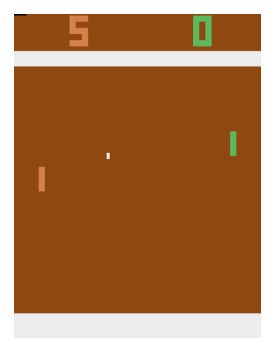

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)